# Summary

* Vector data reading
* Plot spatial data
* Data analysis
* Filter data
* Space Operations
* Export filtered data
* Basic vector x raster statistics
* Create own statistical method
* Raster cutout with vector
* Raster cutout with vector - Buffer
* Export cropped data
* Raster cropped - Statistics
* Homework
* Homework solution

Pra esta aula, foi realizado o download de focos de queima em geojson do site do [INPE - Programa Queimadas](http://queimadas.dgi.inpe.br/queimadas/bdqueimadas#exportar)

In [1]:
!wget https://raw.githubusercontent.com/cicerocasj/teach/master/myData/map.geojson
!wget https://raw.githubusercontent.com/cicerocasj/teach/master/myData/Focos_2019-01-01_2019-12-31.geojson

--2020-01-06 03:52:14--  https://raw.githubusercontent.com/cicerocasj/teach/master/myData/map.geojson
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 317 [text/plain]
Saving to: ‘map.geojson.2’

map.geojson.2       100%[===================>]     317  --.-KB/s    in 0s      

2020-01-06 03:52:14 (98.5 MB/s) - ‘map.geojson.2’ saved [317/317]

--2020-01-06 03:52:15--  https://raw.githubusercontent.com/cicerocasj/teach/master/myData/Focos_2019-01-01_2019-12-31.geojson
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2766900 (2.6M) [text/plain]
S

Let's start by checking if geopandas are installed. To use geopandas in Google Collaboratory you need to use some extra commands.

In [2]:
!pip install -q Shapely==1.6.4.post2 descartes==1.1.0 geopandas==0.4.0 matplotlib==3.0.2 rtree==0.8.3
!apt-get update && apt-get install -yq libspatialindex-dev

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Hit:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Fetched 252 kB in 2s (136 kB/s)
Reading package lists... Done
Reading package lists...
Building depend

# Vector data reading

In [0]:
import geopandas as gpd

geojson = gpd.read_file('Focos_2019-01-01_2019-12-31.geojson')

With the data already in memory read by geopandas, we can now verify its characteristics.

Total Rows and Columns

In [4]:
geojson.shape

(7334, 13)

Geographic projection system

In [5]:
geojson.crs

{'init': 'epsg:4326'}

# Plot spatial data

Along with the installation of geopandas comes the matplotlib library, which we can use to display the maps.

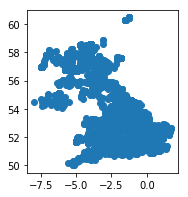

In [6]:
geojson.plot(figsize=(3,3))

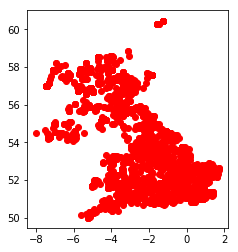

In [7]:
geojson.plot(figsize=(4,4), color='red')

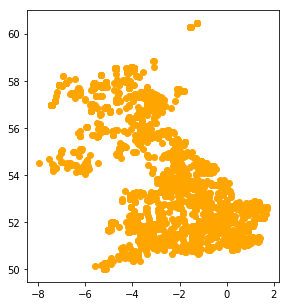

In [8]:
geojson.plot(figsize=(5,5), color='orange')

# Data analysis

Number of Records:

In [9]:
len(geojson)

7334

Amount of log detected by each satellite:

In [10]:
geojson.satelite.value_counts()

NPP-375      6510
AQUA_M-T      335
TERRA_M-M     297
TERRA_M-T     139
AQUA_M-M       35
MSG-03         18
Name: satelite, dtype: int64

Number of registrations by country:

In [11]:
geojson.estado.value_counts()

England             4358
Scotland            2220
Wales                667
Northern Ireland      89
Name: estado, dtype: int64

Top 5 city with largest number of fire.

In [12]:
geojson.municipio.value_counts().head(5)

North Lincolnshire    1844
Highland               837
Fife                   371
South Yorkshire        276
Falkirk                272
Name: municipio, dtype: int64

Day of year with the largest number of burning focus. First you need to pass the datahora field to the "datetime" object.

In [0]:
import pandas as pd
geojson.datahora = pd.to_datetime(geojson.datahora)

In [14]:
geojson.columns

Index(['datahora', 'satelite', 'pais', 'estado', 'municipio', 'bioma',
       'diasemchuva', 'precipitacao', 'riscofogo', 'latitude', 'longitude',
       'frp', 'geometry'],
      dtype='object')

In [15]:
geojson.datahora.dt.date.value_counts()[:1]

2019-02-26    304
Name: datahora, dtype: int64

* Time series

In [0]:
geojson['day'] = geojson['datahora'].dt.date

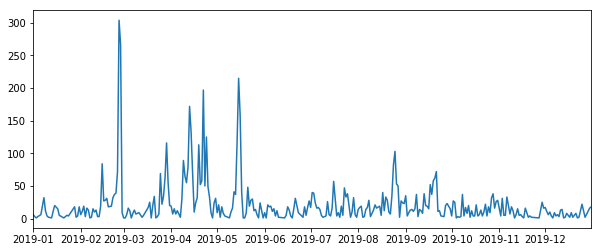

In [17]:
geojson['day'].value_counts().plot(figsize=(10,4))

Accumulated per month

In [0]:
geojson['month'] = geojson['datahora'].dt.month

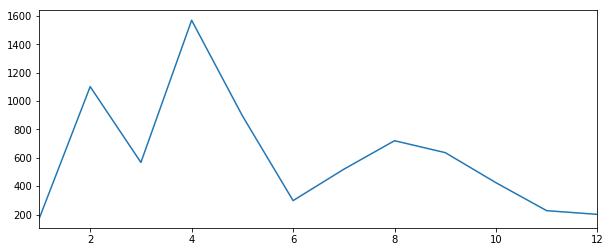

In [19]:
geojson['month'].value_counts().sort_index().plot(figsize=(10,4))

Amount per semester

In [20]:
first_half = geojson[geojson.datahora < '2019-07-01']
second_half = geojson[geojson.datahora >= '2019-07-01']

print('Total first half: %s' % len(first_half))
print('Total second half: %s' % len(second_half))

Total first half: 4607
Total second half: 2727


It should be noted that in the first half of the year, the number of fires was almost double in the second half.

Time of day with highest recurrence of registration

In [21]:
geojson['hour'] = geojson['datahora'] .dt.hour
geojson['hour'].value_counts()

2     1819
12    1478
1     1109
13     978
3      733
11     626
14     198
0      189
4       59
21      46
22      40
10      40
20       7
16       7
17       3
23       2
Name: hour, dtype: int64

Note that the frequency is early in the morning and early afternoon.

# Filter data

We can filter our data based on column values.

Satellite Name

In [22]:
data_filtered = geojson[geojson.satelite == 'NPP-375']
print('Total NPP-375: %s' % len(data_filtered))

Total NPP-375: 6510


Part of the name

In [23]:
data_filtered = geojson[geojson.satelite.str.contains('AQUA')]
print('Total contains AQUA: %s' % len(data_filtered))

Total contains AQUA: 370


# Space Operations

Fire intersecting with an area of interest

In [0]:
area = gpd.read_file('map.geojson')

In [25]:
intersection_data = gpd.sjoin(geojson, area)
print('Total of fires in the area of interest: %s' % len(intersection_data))

Total of fires in the area of interest: 19


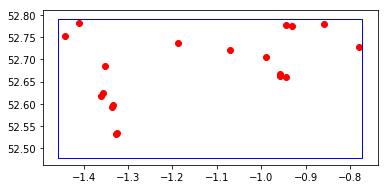

In [26]:
ax = intersection_data.plot(color='r')
area.plot(ax=ax, facecolor='none', edgecolor='blue')

# Export filtered data

We can export data filtered by textual fields or filtered by intersection using the "to_file" method.

* Export to Shapefile

Note: It is not allowed to write data in datetime, date or boolean format. For these cases it is necessary to pass the data to another type, such as str or int.

In [27]:
output_data = intersection_data.copy()
output_data['datahora'] = output_data['datahora'].astype(str)
output_data['day'] = output_data['day'].astype(str)
output_data.to_file('my_shapefile.shp')

/usr/local/lib/python3.6/dist-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


* Export to GeoJson

In [28]:
output_data = intersection_data.copy()
output_data['datahora'] = output_data['datahora'].astype(str)
output_data['day'] = output_data['day'].astype(str)
output_data.to_file('my_shapefile.shp', driver='GeoJSON')

/usr/local/lib/python3.6/dist-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


# Basic vector x raster statistics

We can only get raster information from the area of a given vector. In this example below we will take basic raster statistics by cutting with our area. First let's install the library that will do this hard work.

In [0]:
!pip install rasterstats numpy rasterio -q

Download image - Landsat 8, Band 5, Red.

In [30]:
import urllib.request

url = 'https://landsat-pds.s3.amazonaws.com/c1/L8/202/023/LC08_L1TP_202023_20190826_20190903_01_T1/LC08_L1TP_202023_20190826_20190903_01_T1_B4.TIF'
urllib.request.urlretrieve(url, 'LC08_L1TP_202023_20190826_20190903_01_T1_B4.TIF')

('LC08_L1TP_202023_20190826_20190903_01_T1_B4.TIF',
 <http.client.HTTPMessage at 0x7f000d98c128>)

It is necessary to check if the data is in the same projection, we cannot compare data in different projections.

* Raster projection

In [31]:
import rasterio as rio

with rio.open('LC08_L1TP_202023_20190826_20190903_01_T1_B4.TIF') as src:
  print(src.crs)

EPSG:32630


* Vector projection

In [32]:
print(area.crs)

{'init': 'epsg:4326'}


Since the data is in different projections, we need to leave both with the same projection system. Below we will pass the raster to EPSG: 4326, which is the same one used by our vector.

In [33]:
!gdalwarp -t_srs EPSG:4326 LC08_L1TP_202023_20190826_20190903_01_T1_B4.TIF band_red_4326.tif

Processing input file LC08_L1TP_202023_20190826_20190903_01_T1_B4.TIF.
0...10...20...30...40...50...60...70...80...90...100 - done.


Checking the result

In [34]:
import rasterio as rio

with rio.open('band_red_4326.tif') as src:
  print(src.crs)

EPSG:4326


Now that the data is in the same projection, we can compare with each other.

In [35]:
from rasterstats import zonal_stats

stats = zonal_stats('map.geojson', 'band_red_4326.tif', nodata=-999)[0] # because there are just one polygon

print('Max pixel: %s' % stats.get('max'))
print('Min pixel: %s' % stats.get('min'))
print('Average pixel: %s' % stats.get('mean'))
print('Count pixel: %s' % stats.get('count'))

Max pixel: 62085.0
Min pixel: 5809.0
Average pixel: 8264.582700711006
Count pixel: 1620240


# Create own statistical method

In some situations we need to make our own calculation. This is possible by passing the "add_stats" parameter

In [36]:
import numpy as np

def my_calc(x):
  mean = x.mean()
  return np.count_nonzero((x > mean)==True)

stats = zonal_stats('map.geojson', 'band_red_4326.tif', nodata=-999, stats=['mean'],
                    add_stats={"bigger_than_average": my_calc})[0]
print('Total pixel bigger than average: %s' % stats.get('bigger_than_average'))
print('Average pixel: %s' % stats.get('mean'))

Total pixel bigger than average: 645370
Average pixel: 8264.582700711006


# Raster cutout with vector

We can cut our raster and create a raster with just the area of interest.

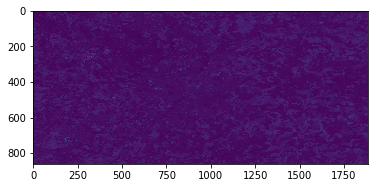

In [37]:
from rasterio.plot import show


path_in = 'band_red_4326.tif'
path_vector = 'map.geojson'
path_raster_out = 'band_red_4326_cropped.tif'

with rio.open(path_in) as src:
  p = src.profile.copy()

nodata = 0

stats = zonal_stats(path_vector, path_in, raster_out=True, nodata=nodata, stats='count')[0]
affine = stats.get('mini_raster_affine')
crop = stats.get('mini_raster_array')
show(crop)

* Raster cutout with vector - Buffer

We can also cut our raster using a buffered vector. Sometimes it is necessary to analyze a little more data around our area of interest.

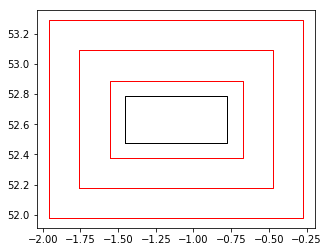

In [38]:
ax = area.plot(edgecolor='black', facecolor='none')
area.buffer(0.1).envelope.plot(edgecolor='red', facecolor='none', ax=ax)
area.buffer(0.3).envelope.plot(edgecolor='red', facecolor='none', ax=ax)
area.buffer(0.5).envelope.plot(edgecolor='red', facecolor='none', ax=ax);

# Export cropped data

Once the data is cut into memory, we can use it along with the input raster attributes to export in the same projection, only by changing the image size and initial position metadata.

In [0]:
crop.data[crop.mask] = nodata

p['transform'] = affine
p['width'] = crop.shape[1]
p['height'] = crop.shape[0]
p['nodata'] = nodata
with rio.open(path_raster_out, 'w', **p) as dst:
  dst.write(crop.astype(p['dtype']), p.get('count'))


# Raster cropped - Statistics

We can now make calculations directed only to the area of interest dataset.

In [40]:
from rasterstats import zonal_stats

stats = zonal_stats('map.geojson', 'band_red_4326_cropped.tif', nodata=-999)[0] # because there are just one polygon

print('Max pixel: %s' % stats.get('max'))
print('Min pixel: %s' % stats.get('min'))
print('Average pixel: %s' % stats.get('mean'))
print('Count pixel: %s' % stats.get('count'))

Max pixel: 62085.0
Min pixel: 5809.0
Average pixel: 8264.582700711006
Count pixel: 1620240


# Homework

Download band 2 (blue), then find out what is the smallest pixel value within a polygon.

# Homework solution

In [41]:
import urllib.request

url = 'https://landsat-pds.s3.amazonaws.com/c1/L8/202/023/LC08_L1TP_202023_20190826_20190903_01_T1/LC08_L1TP_202023_20190826_20190903_01_T1_B2.TIF'
urllib.request.urlretrieve(url, 'LC08_L1TP_202023_20190826_20190903_01_T1_B2.TIF')

('LC08_L1TP_202023_20190826_20190903_01_T1_B2.TIF',
 <http.client.HTTPMessage at 0x7f000d804dd8>)

In [42]:
!gdalwarp -t_srs EPSG:4326 LC08_L1TP_202023_20190826_20190903_01_T1_B2.TIF band_blue_4326.tif

Creating output file that is 9982P x 6075L.
Processing input file LC08_L1TP_202023_20190826_20190903_01_T1_B2.TIF.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [44]:
from rasterstats import zonal_stats

stats = zonal_stats('map.geojson', 'band_blue_4326.tif', stats=['min'])[0]

print('Min pixel of NDVI in my GeoJSON: %s' % stats.get('min'))

Min pixel of NDVI in my GeoJSON: 5183.0


/usr/local/lib/python3.6/dist-packages/rasterstats/io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
